In [232]:
import os
import pandas as pd

import re
import string
import requests
from bs4 import BeautifulSoup
from bs4.diagnose import diagnose

from wordcloud import WordCloud
from textblob import TextBlob
from textblob import Word

from __future__ import division

import matplotlib.pyplot as plt
%matplotlib inline


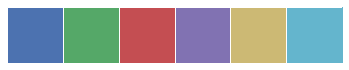

In [236]:
import seaborn as sns

plt.style.use('seaborn-notebook')

sns.set_style('whitegrid')
sns.set_palette('muted')
sns.set(font_scale=2)
sns.set(color_codes=True)
sns.set(rc={'figure.figsize': (6.0, 4.0), 
            'xtick.labelsize': 16, 
            'ytick.labelsize': 16,
            'axes.labelweight': 'bold',
            'legend.fontsize': 16,
            'axes.labelsize': 16,
           'axes.titlesize': 20,
           'axes.titleweight': 'bold'})

current_palette = sns.color_palette()
sns.palplot(current_palette)


In [237]:
def get_text(url):
    '''scrapes debate transcript from New York Times website and returns a string of the text'''
    data=""
    p=requests.get(url).content
    soup=BeautifulSoup(p,'lxml')    
    paragraphs=soup.select("p.story-body-text.story-content")
    data=p
    text=""
    for paragraph in paragraphs:
        text+=paragraph.text
    text=text.encode('ascii', 'ignore')
    return str(text)

In [304]:
def get_text_of_debate(debate):
    '''for a debate number in the format of a string 'debate#' returns debate text'''
    debate_dict = dict()
    debate_dict['debate3'] = get_text('http://www.nytimes.com/2016/10/20/us/politics/third-debate-transcript.html')
    debate_dict['debate2'] = get_text('http://www.nytimes.com/2016/10/10/us/politics/transcript-second-debate.html')
    debate_dict['debate1'] = get_text('http://www.nytimes.com/2016/09/27/us/politics/transcript-debate.html')

    return debate_dict[debate]


In [306]:
def match_speakers(debate):
    '''for a debate number in the format of a string 'debate#' returns a list of speakers in that debate'''
    speaker_dict = dict()
    speaker_dict['debate1'] = ['Trump', 'Clinton','Holt']
    speaker_dict['debate2'] = ['Trump', 'Clinton','Cooper','Raddatz']
    speaker_dict['debate3'] = ['Trump', 'Clinton','Wallace']

    return speaker_dict[debate]

In [325]:
def times_spoken_per_debate(debate):
    '''for a debate returns the times a person spoke'''
    candidate_times = {}
    speakers = match_speakers(debate)

    
    debate_text = get_text_of_debate(debate)
    #print debate_text
    for s in speakers:
        #print s
        s = s.upper() + ':'
        count = len(re.findall(s,debate_text))
        #print s,count
        candidate_times[s.capitalize().strip(':')] = count
        
    if len(speakers) == 3:
        candidate_times['Moderators'] = candidate_times[speakers[2]]
    elif len(speakers) == 4: 
        candidate_times['Moderators'] = candidate_times[speakers[2]] + candidate_times[speakers[3]]
    else:
        print 'ERROR: no speakers found'
    return candidate_times



In [326]:
print 'Interjections in 1st debate'
print times_spoken_per_debate('debate1')
print 'Interjections in 2nd debate'
print times_spoken_per_debate('debate2')
print 'Interjections in 3nd debate'
print times_spoken_per_debate('debate3')

Interjections in 1st debate
{'Moderators': 97, 'Holt': 97, 'Clinton': 94, 'Trump': 129}
Interjections in 2nd debate
{'Cooper': 75, 'Moderators': 136, 'Clinton': 61, 'Trump': 92, 'Raddatz': 61}
Interjections in 3nd debate
{'Moderators': 129, 'Clinton': 84, 'Trump': 129, 'Wallace': 129}


In [356]:
def df_interjections(debate):
    '''returns a dataframe of interjection count give a debate'''
    df = pd.DataFrame.from_dict(times_spoken_per_debate(debate), orient='index')
    if debate == debate1:
        title = 'Interjections in First Debate'
    else:
        title = 'Interjections in Second Debate'
    
    df.columns = ['Interjections']
    names_of_interest = ['Clinton','Trump','Moderators']
    print 'percent that Trump interjected more than Clinton'
    print (df.loc['Trump'] -df.loc['Clinton'])  / df.loc['Clinton']   
    df = df.loc[names_of_interest]
    #df.plot(kind='bar',title = title,legend = False)
    

    
    #ax = df.plot()
    #fig = ax.get_figure()
    #fig.savefig(title + '.png')
    
    #chart =  df.plot(kind='bar',title = title,legend = False)
    
    return df

percent that Trump interjected more than Clinton
Interjections    0.37234
dtype: float64
percent that Trump interjected more than Clinton
Interjections    0.508197
dtype: float64
percent that Trump interjected more than Clinton
Interjections    0.535714
dtype: float64


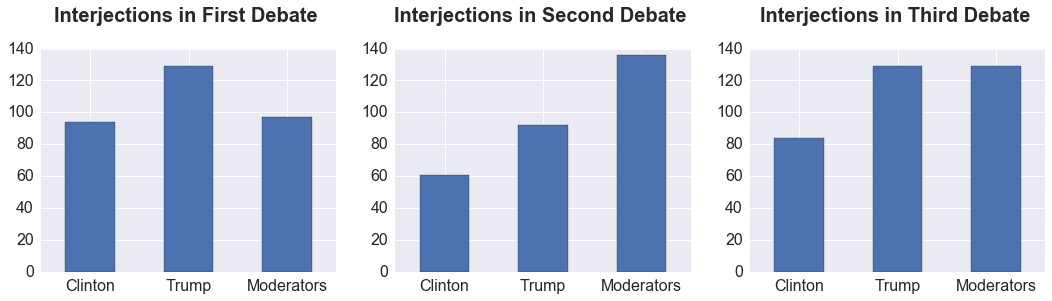

In [357]:
fig, axs = plt.subplots(1,3,figsize=(18,4))

debate_names = [('debate1','First Debate'), ('debate2','Second Debate'), ('debate3','Third Debate')]
count = 0
for d,t in debate_names:
    title = 'Interjections in {0} \n'.format(t)
    df_interjections(d).plot(kind = 'bar',title = title,legend=False,ax=axs[count])
    count += 1
    #df_interjections('debate2').plot(kind = 'bar',title = 'Interjections in Second Debate \n',legend=False, ax=axs[1])
    #df_interjections('debate3').plot(kind = 'bar',title = 'Interjections in Third Debate \n',legend=False, ax=axs[2])


for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
fig.savefig('interjections3' + '.png')

In [337]:
def create_dict_of_debate(debate):
    '''return a dict with speakers as keys for a debate in the format debate1,etc.'''
    debate_dict = {}
    speakers = match_speakers(debate)
    debate_text = get_text_of_debate(debate)

    for x in speakers:
        x = x.upper() + ':'
        debate_text = debate_text.replace('(APPLAUSE)','')
        
        all = re.findall(r'%s(.*?)[A-Z]{3}' %x, debate_text)
        
        #remove Holt intro, the 2nd debate transcript excludes the intro
        if x == 'HOLT:':
            all = all[1:]
        dialogue = "-".join(all) 
        x = x.replace(':','')
        x = x.capitalize()
        debate_dict[x] = dialogue
    return debate_dict



In [428]:
create_dict_of_debate('debate1')

{'Clinton': ' How are you, Donald?- Well, thank you, Lester, and thanks to Hofstra for hosting us.The central question in this election is really what kind of country we want to be and what kind of future well build together. Today is my granddaughters second birthday, so I think about this a lot. First, we have to build an economy that works for everyone, not just those at the top. That means we need new jobs, good jobs, with rising incomes.I want us to invest in you. I want us to invest in your future. That means jobs in infrastructure, in advanced manufacturing, innovation and technology, clean, renewable energy, and small business, because most of the new jobs will come from small business. We also have to make the economy fairer. That starts with raising the national minimum wage and also guarantee, finally, equal pay for womens work.- Well, I think that trade is an important issue. Of course, we are 5 percent of the worlds population; we have to trade with the other 95 percent. A

In [359]:
def convert_dict_to_df(a_dict):
    '''converts a dictionary to a dataframe'''
    debate_df = pd.DataFrame.from_dict(a_dict,orient='index', dtype=None)
    debate_df.rename(columns={0: "text"},inplace = True)
    return debate_df
                 

## Examine Word Count

In [360]:
def print_word_count(debate):
    '''prints word count of debate'''
    print debate
    debate_dict = create_dict_of_debate(debate)
    for key, value in debate_dict.iteritems():
        print key,':',len(value.split(" "))


    trump_words = len(debate_dict['Trump'].split(" "))
    clinton_words = len(debate_dict['Clinton'].split(" "))
    print '% Trump Spoke More than Clinton = {0}'.format((trump_words - clinton_words) / clinton_words)
    print 'Quantity of Words Trump Spoke More than Clinton = {0}'.format(trump_words - clinton_words) 

for x in ['debate1','debate2','debate3']:

    print_word_count(x)
    print '\n'


debate1
Holt : 1648
Clinton : 4457
Trump : 6212
% Trump Spoke More than Clinton = 0.393762620597
Quantity of Words Trump Spoke More than Clinton = 1755


debate2
Cooper : 1051
Clinton : 5230
Trump : 5330
Raddatz : 1068
% Trump Spoke More than Clinton = 0.019120458891
Quantity of Words Trump Spoke More than Clinton = 100


debate3
Clinton : 5471
Trump : 4449
Wallace : 2579
% Trump Spoke More than Clinton = -0.186803143849
Quantity of Words Trump Spoke More than Clinton = -1022




In [362]:
def df_word_count(debate):
    '''given a debate text, plots words spoken by each candidate in each debate'''
    debate_dict = create_dict_of_debate(debate)
    words_spoken_per_debate = {}
    for key, value in debate_dict.iteritems():
        words_spoken_per_debate[key] = len(value.split(" "))
        
    df = pd.DataFrame.from_dict(words_spoken_per_debate, orient='index')
    if debate == debate1:
        title = 'Words Spoken in First Debate'
    else:
        title = 'Words Spoken in Second Debate'
    
    df.columns = ['Interjections']
    names_of_interest = ['Clinton','Trump']
    df = df.loc[names_of_interest]
    
     #v = ['Clinton', 'Trump', 0, 7000]
    #plt.axis(v)
   
   
    #plt.xticks(rotation=0)
    return df

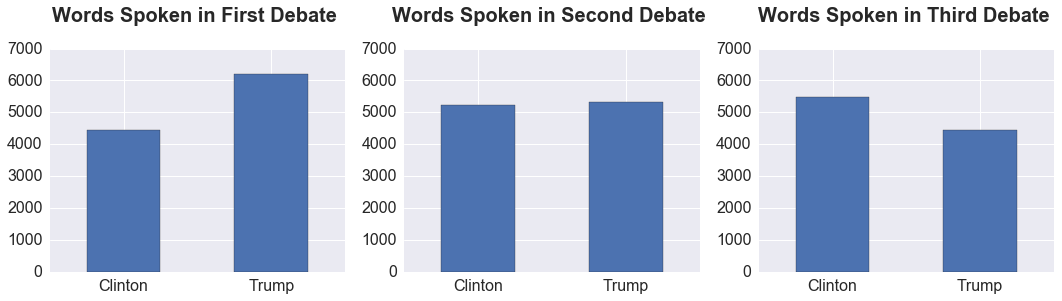

In [366]:
fig, axs = plt.subplots(1,3,figsize=(18, 4))

debate_names = [('debate1','First Debate'), ('debate2','Second Debate'), ('debate3','Third Debate')]

count = 0
for d,t in debate_names:
    df_word_count(d).plot(kind = 'bar',title = 'Words Spoken in {0} \n'.format(t),legend=False,ax=axs[count])
    count +=1

for ax in fig.axes:
    ax.set_ylim([0,7000])
    plt.sca(ax)
    plt.xticks(rotation=0)   
fig.savefig('words' + '.png')


In [367]:
def df_narcissim_index(debate):
    '''given a debate text, plots the narcissism index of each candidate'''
    debate_dict = create_dict_of_debate(debate)
    words_spoken_per_debate = {}
    for key, value in debate_dict.iteritems():
        words_spoken = len(value.split(" "))
        narcissism_count = 0
        for word in value.split(" "):
            if word in ['I',"I'm",'me','mine']:
                narcissism_count +=1
        words_spoken_per_debate[key] = narcissism_count / words_spoken
        
        
    df = pd.DataFrame.from_dict(words_spoken_per_debate, orient='index')
    if debate == debate1:
        title = '"Narcissism Index" \n Self Reference in First Debate'
    elif debate == debate2:
        title = '"Narcissism Index" \n Self Reference in Second Debate'
    elif debate == debate3:
        title = '"Narcissism Index" \n Self Reference in Third Debate'
    df.columns = ['Interjections']

    names_of_interest = ['Clinton','Trump']
    df = df.loc[names_of_interest]
    return df
    #df.plot(kind='bar',title = title,legend = False).set(xlabel='Self Referential Terms ("I","I\'m","me","mine","my","My")')
    
    #plt.xticks(rotation=0)

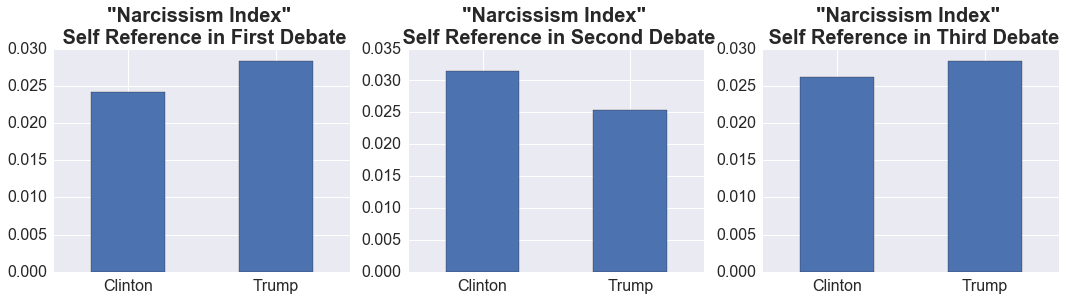

In [369]:
fig, axs = plt.subplots(1,3,figsize=(18,4))

debate_names = [('debate1','First Debate'), ('debate2','Second Debate'), ('debate3','Third Debate')]

count = 0
for d,t in debate_names:
    title = '"Narcissism Index" \n Self Reference in {0}'.format(t)
    df_narcissim_index(d).plot(kind = 'bar',title = title,legend=False,ax=axs[count])
    count +=1


for ax in fig.axes:
    #ax.set_ylim([0,7000])
    plt.sca(ax)
    plt.xticks(rotation=0)   
fig.savefig('narcissism' + '.png')

In [370]:
def generate_wordcloud(df,debate,debate_name):
    '''Generates wordcloud files'''
    speakers = match_speakers(debate)
    for p in speakers:
        print("Generating: %s" % p)
        
        wordcloud = WordCloud( max_words=500, width=450, height=300, background_color='white')
        text    =  df[df.index == p]['text'].get_values()[0]
        blob    = TextBlob(text)
        nouns   = [ word for word, pos in blob.tags if pos == 'NN' ]

        wordcloud.generate(' '.join(nouns))
        
        image = wordcloud.to_image()
        
        #matplotlib.pyplot.imshow(image)
        #fig, axs = plt.subplots(1,2,figsize=(16,6))
        fig = plt.figure()
        title = p + ' ' + debate_name
        fig.suptitle(title, fontsize=14, fontweight='bold')
        plt.imshow(image)
        plt.axis("off")
        wordcloud_filename = p.lower() + debate_name +'.png'
        plt.savefig(wordcloud_filename)
    

def plot_wordclouds(debate,debate_name):
    
    debate_dict = create_dict_of_debate(debate)
    df = convert_dict_to_df(debate_dict)
    generate_wordcloud(df,debate,debate_name)



Generating: Trump
Generating: Clinton
Generating: Cooper
Generating: Raddatz


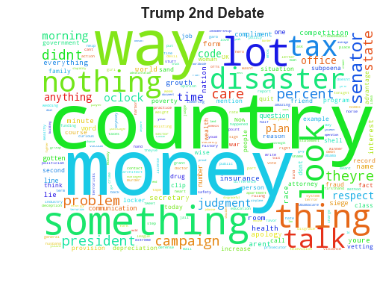

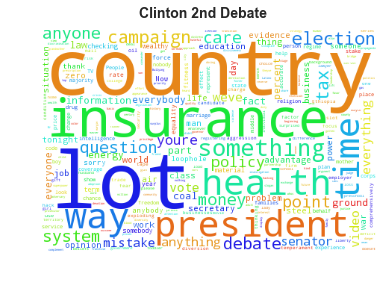

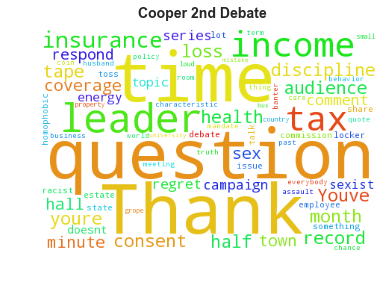

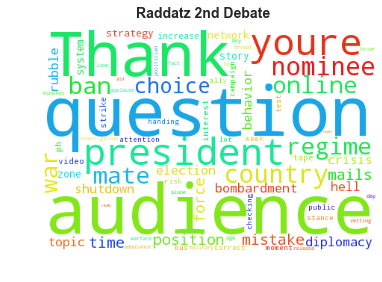

In [375]:
plot_wordclouds('debate2', '2nd Debate')


In [492]:
def create_dict_of_periods_of_debate(debate, period, total_periods):  
    '''divides a debate into periods and returns a dictionary of text from each each speaker'''
    debate_dict = {}
    debate_text = get_text_of_debate(debate)  

    debate_text = debate_text.replace('(APPLAUSE)', '')
    speakers = match_speakers(debate)  

    period = period - 1  
    chunk_size = int(len(debate_text) / total_periods) 
    i = period * chunk_size
    debate_text = debate_text[i: i + chunk_size]  

    for x in speakers:  
       x = x.upper() + ':'
       all = re.findall(r'%s(.*?)[A-Z]{3}' %x,  debate_text) 

       #remove Holt intro  the 2nd debate transcript excludes the intro  
       if x == 'HOLT:':
           all = all[1:]  
       dialogue = "-".join(all)   
       x = x.replace(':', '')
       x = x.capitalize()  
       debate_dict[x] = dialogue  
    return debate_dict 

In [493]:

def get_sentiment_analysis(speaker,debate,period,total_periods):
    debate_dict = create_dict_of_periods_of_debate(debate,period,total_periods)
    transcript = TextBlob(debate_dict[speaker])
    n =  transcript.sentiment.polarity
    return round(n,6)
    

def create_dataframe_of_sentiment(debate,total_periods,speakers):

    time_periods = [x for x in xrange(1,(total_periods+1))]
    df = pd.DataFrame(index= time_periods)
    
    for y in speakers:
        df[y] = [get_sentiment_analysis(y,debate,x,total_periods) for x in xrange(1,(total_periods+1))]
        df[y] = [get_sentiment_analysis(y,debate,x,total_periods) for x in xrange(1,(total_periods+1))]
        
    return df




## Test Create sentiment analysis of Winnebego man

In [494]:
winnebego_text = u'''The Winnebago concept on engineering department has developed the multi functional bathroom, privacy I don't know what the fuck I'm reading. I wonder what the fuck the real dialogue is. What the fuck is this thing? Under the windshield for fucks say. Oh fuck. What the fuck did I say? That didn't' sound for shit did it? Trying to give these guys everything they can get from me. That's it, fuck it. I don't know that the fuck I'm saying. How do you suppose we open. Got to do it again right now. Oh fuck! Fuck! Fuck! Fuck! Shit! Tony do me a favor please. Will you do me a kindness? It doesn't make a difference to me at this juncture. Thank you very much I appreciate that Tony. Don't slam the fucking door. No more! Listen I got to give a clue here now. I don't want any more bullshit any time during the day from anyone that includes me. It's going to be very hot, very uncomfortable for everybody. I don't want anybody yelling. We get anybody yelling around here anymore today and then the shit is going to hit the fan. They may fit the needs of a very diverse buyer's segment. Why can't I remember it! I wrote this stuff, why can't I remember it. Why don't I say it fucking right? What is the god damn line say? What is the god damn line? I don't give a shit what the line is. I fucked up the word rear. I can't even read the VO straight. What the fuck was that. We got flies all over the fucking place. Son of a bitch, get out of here you fucking flies. There is a fly over the headlight Tony. We got flies coming for us, fuck. Get the fuck out of here you flies. We got 3 flies, 5 flies. Make sure if you will we don't have the fly on the left side of the passenger side but make sure we don't have any flies. Here we go. Get out of her you God damn jackass. I got to read it again because my mind is a piece of shit this morning. I can't make my mind work. Tony gives me a towel for a minute please. I'm blinded by that bucket of god damn son of a bitch. What do you mean, I'm about to fall off the fucking thing. Fuck, just keep running. Bull shit I'm going to slay this fucker. I haven't got time to mark this mother fucker. Here we go again, we can't hear anybody, no one can talk to anybody. Well turn the fucking thing off. You dumbass. I'd like to kick your fucking head in. Meet innovation, money fuck not even funny anymore. Son of a bitch! Jesus Christ. Fuck! Son of a bitch! Jesus Christ. Fuck! Shit! Son of a Bitch. Jesus Christ. Fuck! Shit! Son of a Bitch. Jesus Christ. Fuck! Shit! Son of a Bitch. Jesus Christ. Oh fuck off. What the hell is the line. I can't remember the line. It's just all gone. I get some god damn diuretic when I sit here and my mouth doesn't stop. Not this shit. The mini Winnie, part of American tradition and today the cutting edge of design and function in a Class C motor home. DO you belie any of that shit?'''.encode("utf8")

transcript = TextBlob(winnebego_text)
n =  transcript.sentiment.polarity

n

-0.1933503401360544

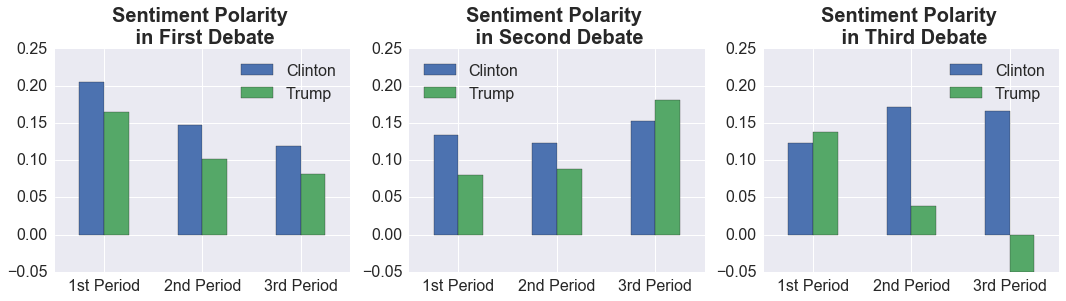

In [496]:
fig, axs = plt.subplots(1,3,figsize=(18,4))

count = 0
for d,t in debate_names:
    title = 'Sentiment Polarity \n in {0}'.format(t)
    df = create_dataframe_of_sentiment(d,3,['Clinton','Trump'])
    df.plot(kind = 'bar',title = title,legend=True,ax=axs[count])
    count +=1

for ax in axs: 
    ax.set_xticklabels( ['1st Period','2nd Period','3rd Period'], rotation=0 ) 
    ax.set_ylim([-.05,.25])
#plt.xticks(rotation=0)
fig = ax.get_figure()
fig.savefig('sent_redo' + '.png')


In [ ]:
df2 = create_dataframe_of_sentiment(debate3,3,['Clinton','Trump'])

ax = df2.plot(kind = 'bar',title = 'Sentiment Polarity in 3rd Debate')
ax.set_xticklabels( ['1st Period','2nd Period','3rd Period'], rotation=45 ) 


plt.xticks(rotation=0)

#plt.set.xlabel='30 Minute Period of Debate'
fig = ax.get_figure()
fig.savefig('second' + '.png')